<a href="https://colab.research.google.com/github/s-mostafa-a/pytorch_learning/blob/master/simple_generative_adversarial_net/CIFAR10_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified


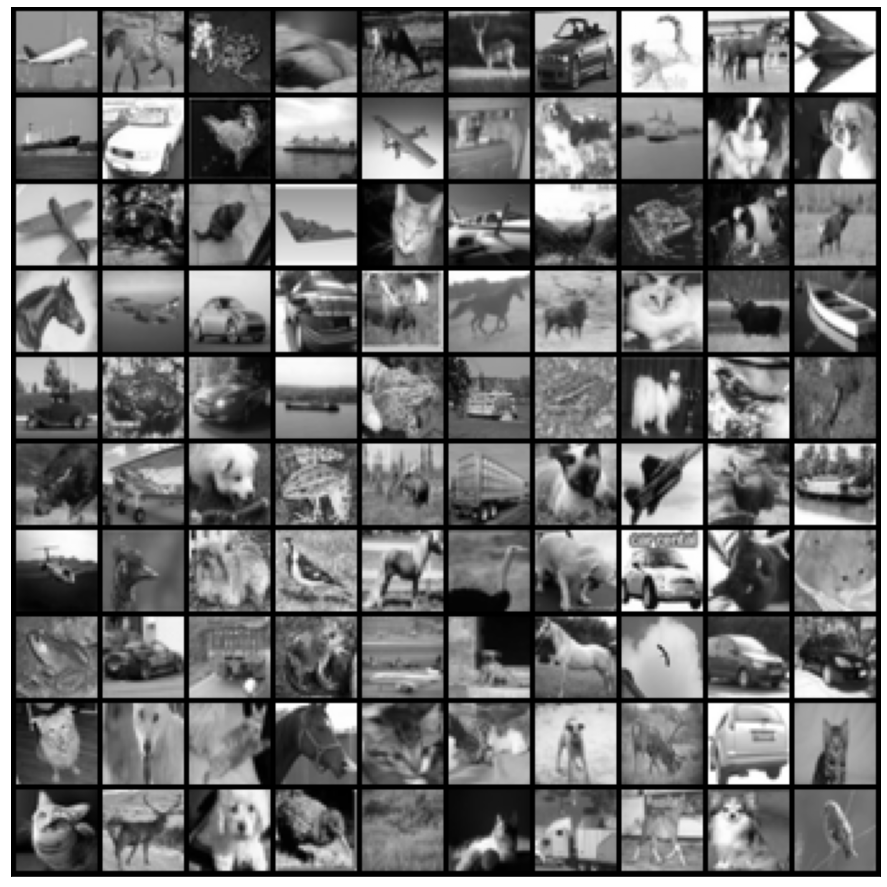

In [0]:
%matplotlib inline
import torch
from torchvision.transforms import ToTensor, Normalize, Compose, Grayscale, RandomCrop, RandomHorizontalFlip, Normalize, ToPILImage
from torchvision.datasets import CIFAR10
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield self.to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

    def to_device(self, data, device):
        if isinstance(data, (list, tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
class Generator(nn.Module):
  def __init__(self, latent_size, hidden_size, image_size, device):
    super().__init__()
    self.G = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh())
    self.device = device
  def forward(self, x):
    output = self.G(x)
    output = torch.tensor((output + 1) / 2, dtype=torch.float32).to(self.device)
    return output

class CIFAR10_GANS:
    def __init__(self, dataset, image_size, device, num_epochs=50, loss_function=nn.BCELoss(), batch_size=100,
                 hidden_size=11264, latent_size=64):
        self.device = device
        bare_data_loader = DataLoader(dataset, batch_size, shuffle=True)
        self.data_loader = DeviceDataLoader(bare_data_loader, device)
        self.loss_function = loss_function
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.batch_size = batch_size
        self.D = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid())
        self.G = Generator(latent_size=latent_size, hidden_size=hidden_size, image_size=image_size, device=device)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=0.0005)
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=0.0005)
        self.sample_dir = './../data/cifar_samples'
        if not os.path.exists(self.sample_dir):
            os.makedirs(self.sample_dir)
        self.G.to(device)
        self.D.to(device)
        self.sample_vectors = torch.randn(self.batch_size, self.latent_size).to(self.device)
        self.save_fake_images(0)
        self.num_epochs = num_epochs

    def reset_grad(self):
        self.d_optimizer.zero_grad()
        self.g_optimizer.zero_grad()

    def train_discriminator(self, images):
        real_labels = torch.ones(self.batch_size, 1).to(self.device)
        fake_labels = torch.zeros(self.batch_size, 1).to(self.device)

        outputs = self.D(images)
        d_loss_real = self.loss_function(outputs, real_labels)
        real_score = outputs

        new_sample_vectors = torch.randn(self.batch_size, self.latent_size).to(self.device)
        fake_images = self.G(new_sample_vectors)
        outputs = self.D(fake_images)
        d_loss_fake = self.loss_function(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        self.reset_grad()
        d_loss.backward()
        self.d_optimizer.step()

        return d_loss, real_score, fake_score

    def train_generator(self):
        new_sample_vectors = torch.randn(self.batch_size, self.latent_size).to(self.device)
        fake_images = self.G(new_sample_vectors)
        labels = torch.ones(self.batch_size, 1).to(self.device)
        g_loss = self.loss_function(self.D(fake_images), labels)
        self.reset_grad()
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss, fake_images

    def save_fake_images(self, index):
        fake_images = self.G(self.sample_vectors)
        fake_images = fake_images.reshape(fake_images.size(0), 1, 32, 32)
        fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
        print('Saving', fake_fname)
        save_image(fake_images, os.path.join(self.sample_dir, fake_fname),
                   nrow=10, )

    def run(self):
        total_step = len(self.data_loader)
        d_losses, g_losses, real_scores, fake_scores = [], [], [], []

        for epoch in range(self.num_epochs):
            for i, (images, _) in enumerate(self.data_loader):
                images = images.reshape(self.batch_size, -1)

                d_loss, real_score, fake_score = self.train_discriminator(images)
                g_loss, fake_images = self.train_generator()

                if (i + 1) % 500 == 0:
                    d_losses.append(d_loss.item())
                    g_losses.append(g_loss.item())
                    real_scores.append(real_score.mean().item())
                    fake_scores.append(fake_score.mean().item())
                    print(f'''Epoch [{epoch}/{self.num_epochs}], Step [{i + 1}/{
                    total_step}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {
                    real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}''')
            self.save_fake_images(epoch + 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transforms = Compose([ToTensor(), 
                      ToPILImage(),
                      Grayscale(),
                      ToTensor()])
cifar = CIFAR10(root='./../data', train=True, download=True, transform=transforms)
image_size = 1024

dl = DataLoader(cifar, batch_size=100, shuffle=True, num_workers=8, pin_memory=True)
for images, labels in dl:
  fig, ax = plt.subplots(figsize=(16, 16))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
  break






In [0]:
gans = CIFAR10_GANS(dataset=cifar, image_size=image_size, device=device)
gans.run()